# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
# General Utilities for Web Scraping
import re
import sys
import os
from os import listdir
from os.path import isfile, join, isdir
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import date, datetime
from dateutil import relativedelta
import csv
import json
import collections
from collections import defaultdict
from collections import Counter

# Machine Learning Utitilies
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import seaborn as sns

# plotting defaults
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)
get_colors = lambda length: plt.get_cmap('Spectral')(np.linspace(0, 1.0, length))

# Pyspark
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import (
    udf, 
    desc, 
    asc, 
    sum as Fsum,
    lag,
    row_number,
    col,
    count,
    when
)
from pyspark.sql.types import StringType, IntegerType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import (
    LogisticRegression, 
    RandomForestClassifier, 
    GBTClassifier,
    MultilayerPerceptronClassifier
)
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)

In [3]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.driver.port', '64302'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'chengyis-mbp'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1564368114676')]

# Preliminaries

What could cause users to **CHURN**? There can be multiple reasons why users would churn, including the following:
1. Ineffective Recommendation System of Sparkify
    - e.g. Users listen to mostly rock genres, but recommendation system recommends songs way too out of the scope of rock 
2. Bad UI / UX Design of Sparkify
    - e.g. Navigation through the application might be tedious, causing some users to churn and turn to substitutes
3. Users might be interested in listening to songs that are not available on Sparkify
    - e.g. If the main demographic that's churning are parents that only want to have Sesame  Street and Baby songs on their phones, they might end up churning because Sparkify does not support those songs
4. The Premium tier of Sparkify might be too expensive, while the free tier might support fewer services than alternatives

Depending on which of these problems (or combination of problems) caused the customer to churn, it would affect 
1. How we predict whether a customer will churn
    - We could formulate this as either a binary classification task like "**Will** a user churn or not?"
    - We could further ask "**When** a user will churn if they will churn at all
        - Furthermore, instead of predicting a single value as to when the customer will churn, we can predict a probability distribution such as [exponential](https://www.digitalmarketer.com/blog/customer-retention-rates/) to model how long it'll take for the customer to churn given past behavior
    - Also, we could further adapt this with a probablistic perspective - "**What** is the probability that a user will churn given his/her past activity"
2. Solution to reduce churn rates
    - If the problem was related to 1 or 2, we might use an A/B Test to see whether changing the UI / UX  or Recommendation System might decrease churn rates
    - If the problem was more of 3, we could possibly add support for those songs if the demographic is large enough or provide family plan discounts to entice them to continue with the service
    
Because of how complicated we can frame the problem, we will first build a simplified model - a soft classification as to whether a customer will churn or not. Subsequently, if we have the time, we will build a model that'll [predict a probability distribution](https://icml.cc/Conferences/2005/proceedings/papers/015_Predicting_CarneyEtAl.pdf) as to when the customer will churn - give probabilities as to whether a customer will churn as time passes

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_user_log.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
path = "./data/mini_sparkify_event_data.json"
user_log = spark.read.json(path)
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
user_log.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [7]:
user_log.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [8]:
user_log.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [9]:
# # If you need to save it into csv
# out_path = "./data/mini_sparkify_event_data.csv"
# user_log.write.save(out_path, format='csv', header=True)

In [10]:
user_log.describe("length").show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            228108|
|   mean|249.11718197783478|
| stddev| 99.23517921058324|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



In [11]:
user_log.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [12]:
user_log.describe("userId").show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            286500|
|   mean| 59682.02278593872|
| stddev|109091.94999910604|
|    min|                  |
|    max|                99|
+-------+------------------+



In [13]:
user_log.select(["userId", "firstName", "page", "song"]) \
    .where(user_log.userId == "99") \
    .collect()[:10]

[Row(userId='99', firstName='Madison', page='Home', song=None),
 Row(userId='99', firstName='Madison', page='NextSong', song='Welcome (Album Version)'),
 Row(userId='99', firstName='Madison', page='NextSong', song='Si No Existo (Live)'),
 Row(userId='99', firstName='Madison', page='NextSong', song='Moments with Oliver'),
 Row(userId='99', firstName='Madison', page='NextSong', song='Si Do Mhaimeo I'),
 Row(userId='99', firstName='Madison', page='Thumbs Down', song=None),
 Row(userId='99', firstName='Madison', page='NextSong', song='Coleccionista De Canciones'),
 Row(userId='99', firstName='Madison', page='Roll Advert', song=None),
 Row(userId='99', firstName='Madison', page='NextSong', song='Opposite Of Adults'),
 Row(userId='99', firstName='Madison', page='Thumbs Up', song=None)]

Let's find how many songs a user listens to in an hour.

In [14]:
# Spark User-defined Function toget hours from timestamp
get_hour = udf(lambda x: datetime.fromtimestamp(x / 1000.0).hour)

# Convert ts column to hours
user_log = user_log.withColumn("hour", get_hour(user_log.ts))
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='8')

See that Colin listened to Rockpools at 8am. We'll now group the songs by the hour to determine how many songs was listened to in each  hour by each user.

In [15]:
songs_in_hour = user_log.filter(
    user_log.page == "NextSong"
).groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|11636|
|   1|11460|
|   2|11124|
|   3|10930|
|   4|10856|
|   5|10458|
|   6|10122|
|   7| 9630|
|   8| 9062|
|   9| 8388|
|  10| 8336|
|  11| 8355|
|  12| 8147|
|  13| 8178|
|  14| 8054|
|  15| 8091|
|  16| 8253|
|  17| 8498|
|  18| 8882|
|  19| 8830|
+----+-----+
only showing top 20 rows



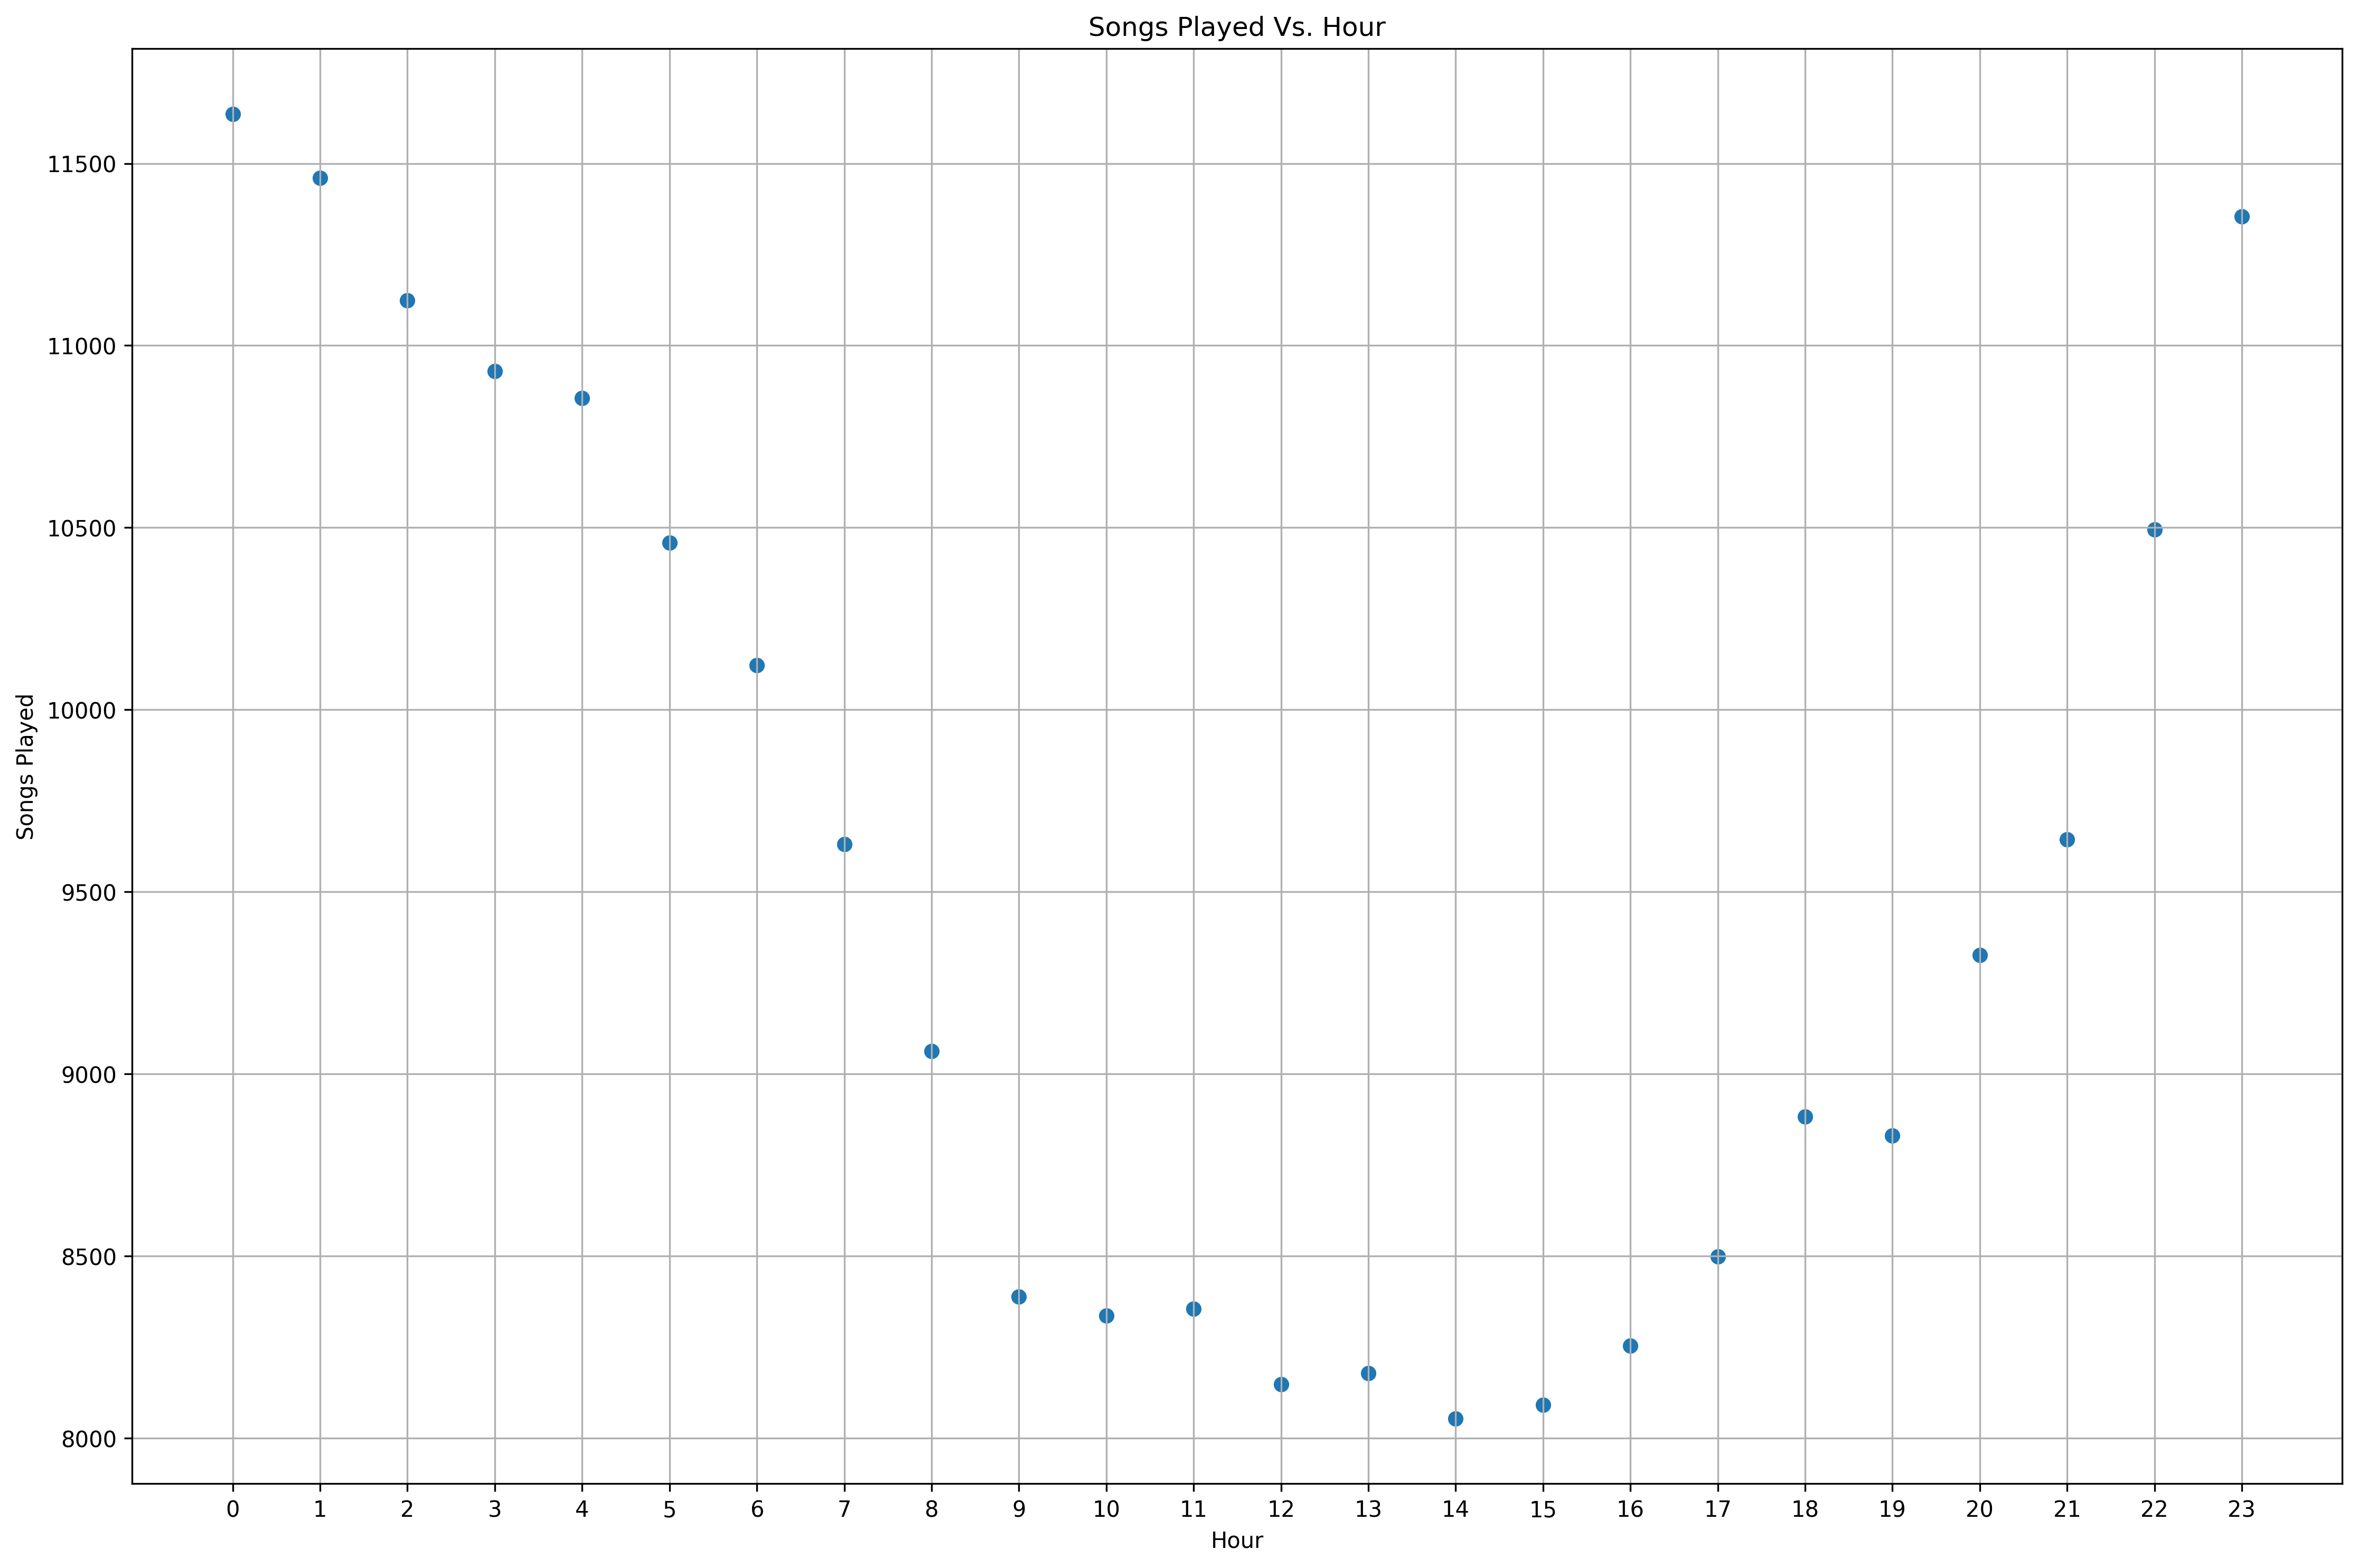

In [16]:
songs_in_hour_pd = songs_in_hour.toPandas()

fig, ax = plt.subplots(1,1)
ax.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
ax.set_xlabel("Hour")
ax.set_ylabel("Songs Played")
ax.set_title("Songs Played Vs. Hour")
ax.grid()
plt.show();

In [17]:
user_log_valid = user_log.dropna(how='any', subset=["userId", "sessionId"])
user_log_valid.count()

286500

In [18]:
user_log_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



Weird, there is an empty string as the `userId`, let's remove all the `userId`s with an empty string and count again.

In [19]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")
user_log_valid.count()

278154

This way, we've only included `userId`s that have a valid value.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

We want to distinguish a user's activity before and after a particular event such as `Cancellation Confirmation` and `Submit Downgrade`.

In [118]:
user_log_valid.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|   8|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|

### Churn Rate Part 1: `Cancellation Confirmation`

We will utilize the `Cancellation Confirmation` event to define our churn rate.

In [20]:
# Find all users that have confirmed to cancel the service
user_log_valid.filter("page = 'Cancellation Confirmation'").show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|   4|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (

How many users have cancelled the service?

In [21]:
# Number of users that have cancelled the service
user_log_valid \
    .filter("page = 'Cancellation Confirmation'") \
    .select("userId") \
    .dropDuplicates() \
    .count()

52

Let's take a look at Adriel's activity using Spark Dataframes to understand why he cancelled the service.

In [22]:
adriel_log = user_log_valid.select([
        "userId", 
        "sessionId",
        "firstName", 
        "page", 
        "level", 
        "hour"]) \
    .where(user_log_valid.userId == "18") \
    .withColumn("row_num", 
                row_number().over(Window.partitionBy("userId").orderBy("userId"))) \
    .withColumn("prev_hour",
                lag(user_log_valid.hour.cast("float"), count=1).over(Window.partitionBy("userId").orderBy("row_num"))) \
    .fillna(1.0) \
    .withColumn("change_hour_row_num", (col("hour") != col("prev_hour")).cast("float") * col("row_num")) \
    .filter(col("change_hour_row_num") != 0.0) \
    .withColumn("change_hour_row_num_prev",
                lag(col("change_hour_row_num").cast("float"), count=1).over(Window.partitionBy("userId").orderBy("row_num"))) \
    .fillna(0.0) \
    .withColumn("total_songs_per_hour", 
                lag(col("change_hour_row_num") - col("change_hour_row_num_prev"), count=-1).over(Window.partitionBy("userId").orderBy("row_num"))) \
    .fillna(1.0) \
    .drop("prev_hour").drop("change_hour_row_num").drop("change_hour_row_num_prev")

adriel_log.show()

+------+---------+---------+---------------+-----+----+-------+--------------------+
|userId|sessionId|firstName|           page|level|hour|row_num|total_songs_per_hour|
+------+---------+---------+---------------+-----+----+-------+--------------------+
|    18|      242|   Adriel|       NextSong| paid|   2|     19|                19.0|
|    18|      242|   Adriel|       NextSong| paid|   3|     38|                16.0|
|    18|      242|   Adriel|       NextSong| paid|   4|     54|                20.0|
|    18|      242|   Adriel|       NextSong| paid|   5|     74|                18.0|
|    18|      360|   Adriel|       NextSong| paid|   6|     92|                17.0|
|    18|      360|   Adriel|       NextSong| paid|   7|    109|                13.0|
|    18|      363|   Adriel|       NextSong| paid|  14|    122|                 7.0|
|    18|      363|   Adriel|       NextSong| paid|  15|    129|                15.0|
|    18|      363|   Adriel|       NextSong| paid|  16|    144|  

In [23]:
# Create list of tuples
# (hour, total songs in that hour)
total_songs_each_hour = [
    (int(row["hour"]), int(row["total_songs_per_hour"])) \
    for row in adriel_log.select("hour", "total_songs_per_hour").collect()]

# Find First hour user started using Sparkify
# and prepend hours before that hour until 12 midnight
first_hour_on_sparkify = total_songs_each_hour[0][0]

# Find Last hour user started using Sparkify
# and append hours after that hour until 12 midnight
last_hour_on_sparkify = total_songs_each_hour[-1][0]

total_songs_each_hour = [(hour, 0) for hour in list(np.arange(24))[:first_hour_on_sparkify]] \
                        + total_songs_each_hour \
                        + [(hour, 0) for hour in list(np.arange(24))[last_hour_on_sparkify+1:]] 

# Insert tuples of (hour, 0)
# for all the times user was inactive
# on Sparkify
hour = 0
while True:
    if hour < len(total_songs_each_hour):
        if hour % 24 != total_songs_each_hour[hour][0]:
            total_songs_each_hour.insert(hour, (hour % 24, 0))
        hour += 1
    else:
        break
        
# Get the user activity from the first hour 
# they started Sparkify
hours, total_songs_per_hour = list(zip(*total_songs_each_hour))

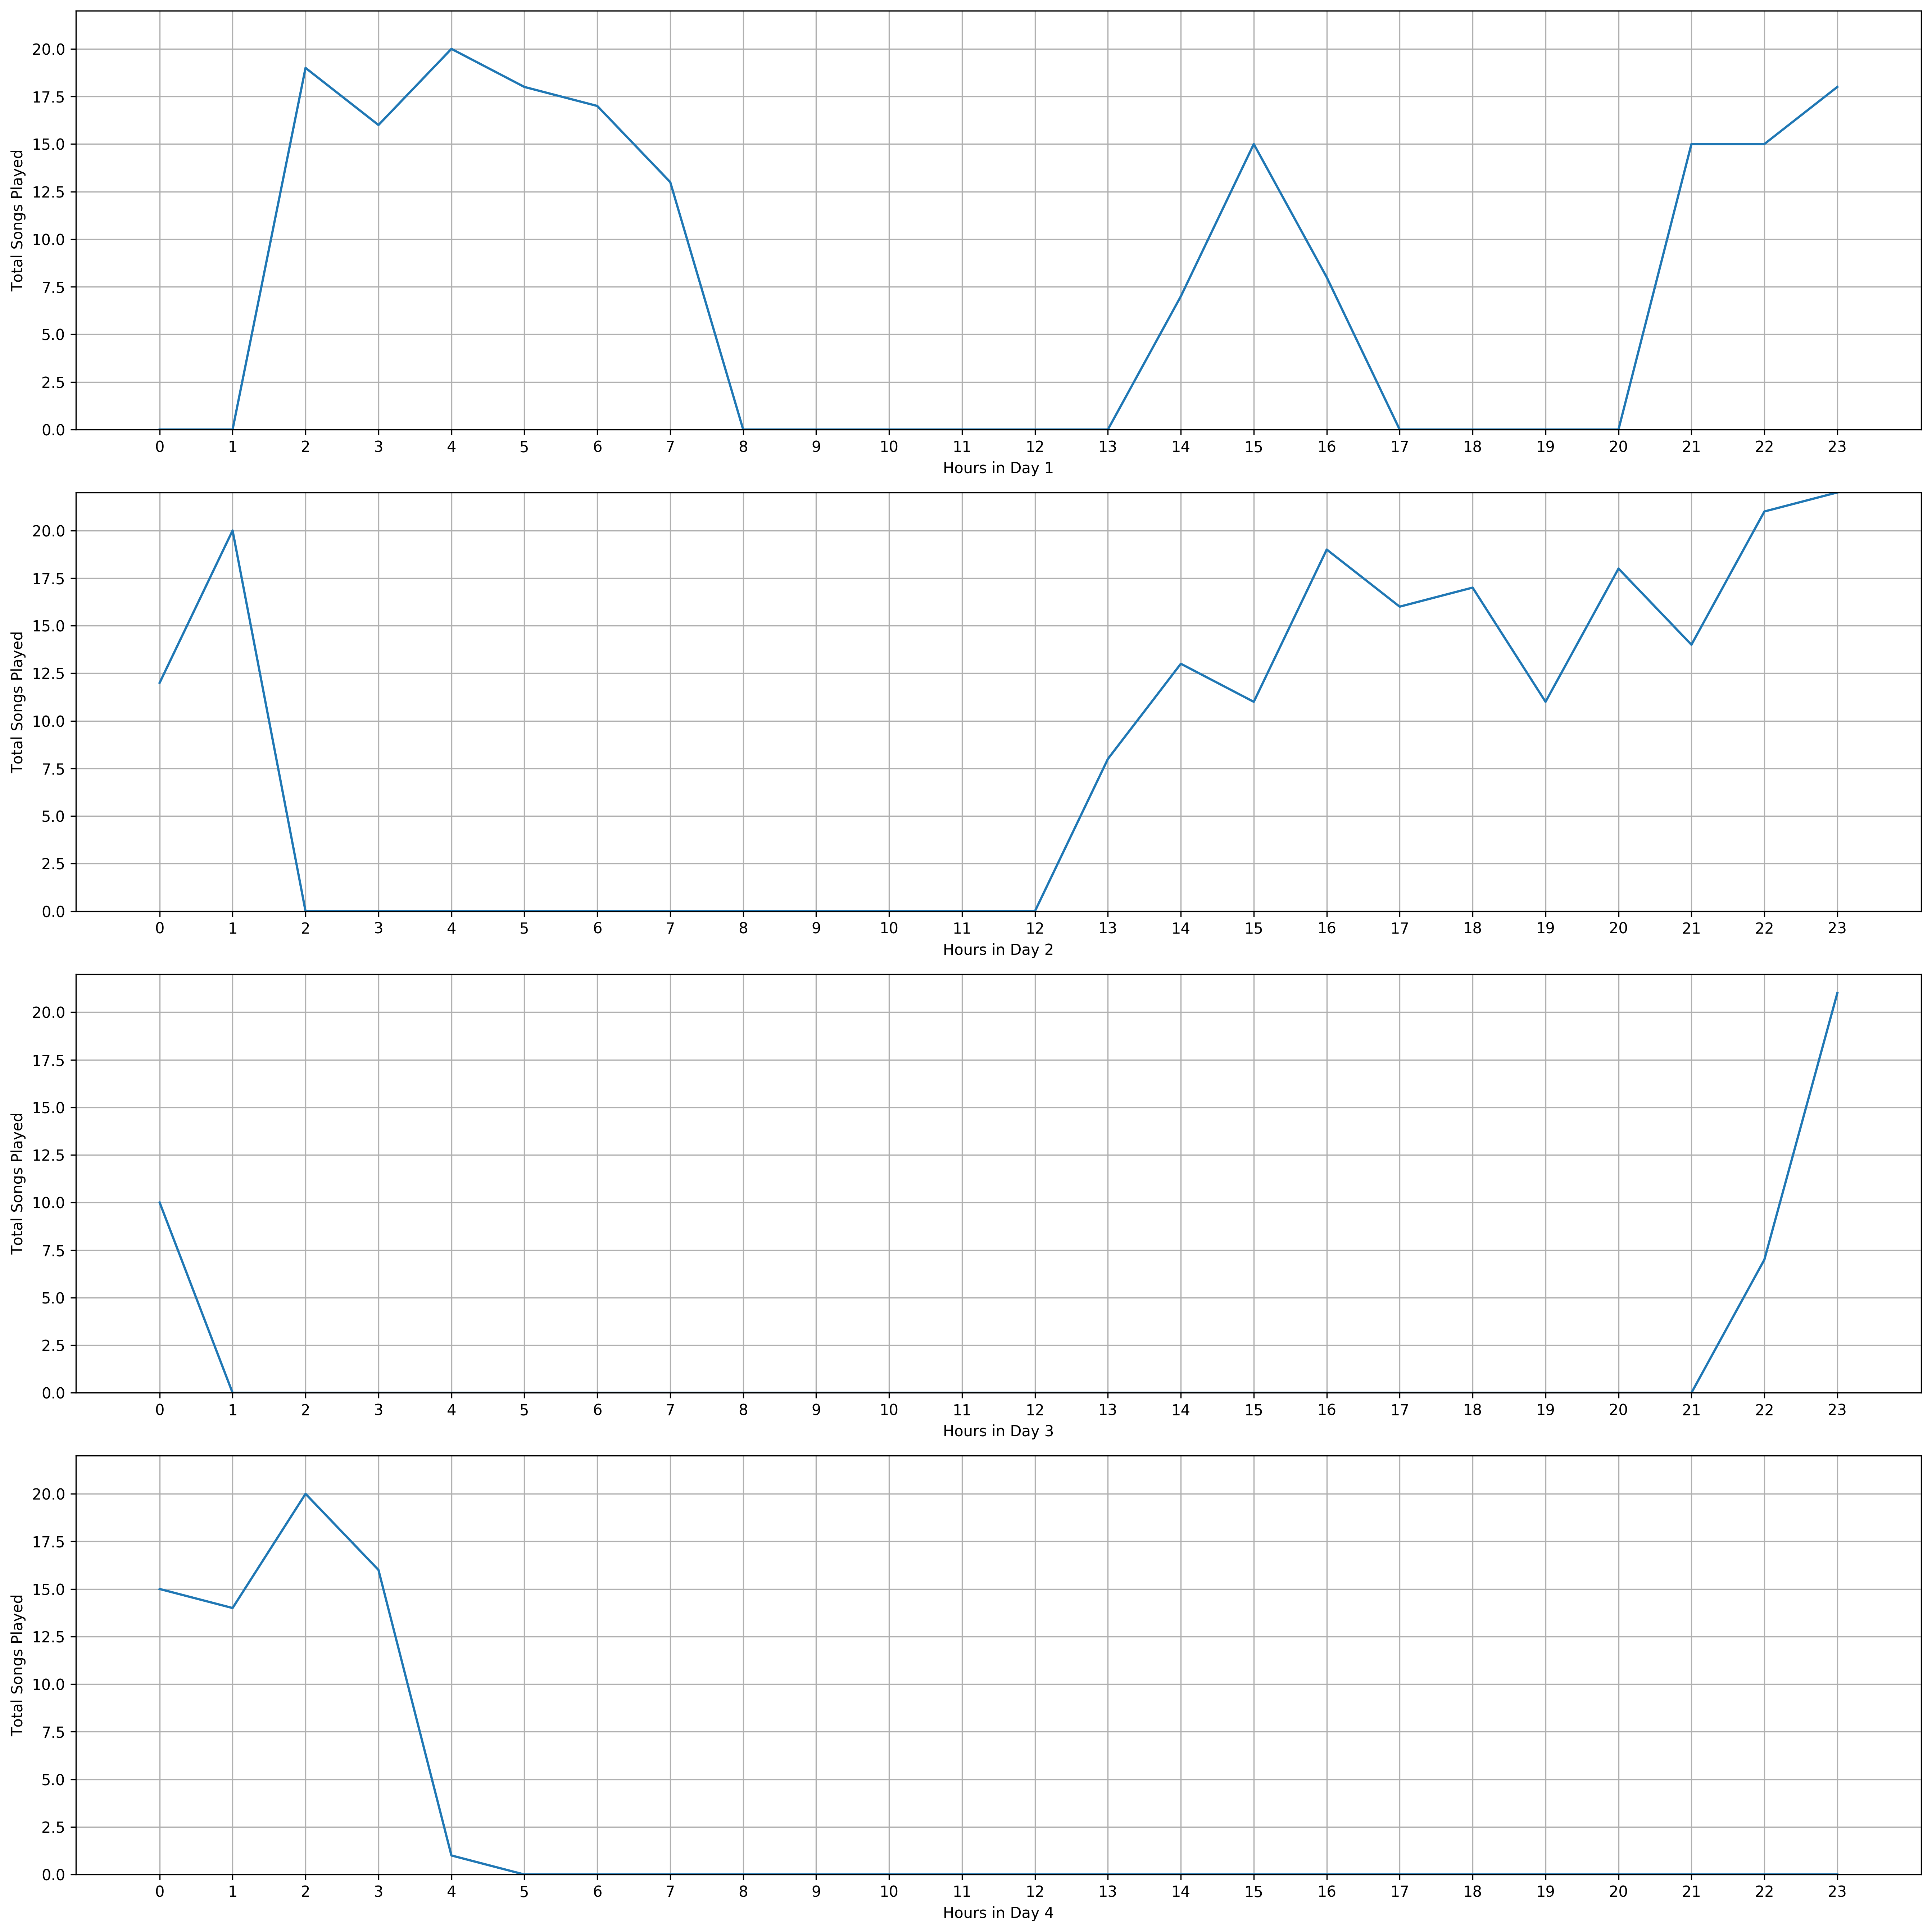

In [24]:
# Plot the user activity per day
n = 24 # Number of hours for each plot
plt.rcParams['figure.figsize'] = (18, 18)
fig, axs = plt.subplots(int(np.ceil(len(total_songs_per_hour) / n)), 1)

for idx, ax in enumerate(axs):
    if (idx+1)*n < len(total_songs_per_hour):
        ax.plot(np.arange(n), total_songs_per_hour[idx*n:(idx+1)*n])
        ax.set_xticks(np.arange(n))
        ax.set_xticklabels(hours[idx*n:(idx+1)*n])
    else:
        ax.plot(np.arange(len(total_songs_per_hour[idx*n:])), total_songs_per_hour[idx*n:])
        ax.set_xticks(np.arange(len(total_songs_per_hour[idx*n:])))
        ax.set_xticklabels(hours[idx*n:])
    ax.grid()
    ax.set_xlabel("Hours in Day {}".format(idx+1))
    ax.set_ylim(0, np.max(total_songs_per_hour))
    ax.set_ylabel("Total Songs Played")
    
plt.tight_layout()
plt.show();

Let's create a column `Churn` using Spark SQL (Both Spark SQL and Spark Data Frames use the Spark SQL Catalyst Optimizer to optimize queries) to use as the label for your model

In [25]:
# Create temporary SQL Table
user_log_valid.createOrReplaceTempView("log_table")

# Let's get all the users that have cancelled 
# the service and add a boolean column with 1 
# if they churned eventually and 0 if they did not
user_churn_df = spark.sql(
'''
SELECT distinct_users.userId, 
CASE 
    WHEN CAST(churned_users.userId AS INT) IS NULL THEN 0
    ELSE 1
END AS churned
FROM (
    SELECT DISTINCT CAST(log_table.userId AS INT)
    FROM log_table
    ORDER BY 1
) AS distinct_users
FULL OUTER JOIN (
    SELECT CAST(log_table.userId AS INT)
    FROM log_table
    WHERE page = 'Cancellation Confirmation'
    ORDER BY 1
) AS churned_users
ON distinct_users.userId = churned_users.userId
ORDER BY 1
'''
)

user_churn_df.show(10)

+------+-------+
|userId|churned|
+------+-------+
|     2|      0|
|     3|      1|
|     4|      0|
|     5|      0|
|     6|      0|
|     7|      0|
|     8|      0|
|     9|      0|
|    10|      0|
|    11|      0|
+------+-------+
only showing top 10 rows



### Churn Rate Part 2: `Submit Downgrade`

We will utilize the `Submit Downgrade` event to define our churn rate.

In [26]:
# Find all users that have downgraded their service from paid tier to free
user_log_valid.filter("page = 'Submit Downgrade'").show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|     Kael|     M|           47|   Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|  19|
|  null|Logged In|   Calvin|     M|           17|Marshall|  null| paid|      Pittsburgh, PA|   PUT|Submit Downgrade|1537120757000|      313|null|   307|1538516445000|"Mozilla/5.0 (Mac...|    38|   5|


How many users have downgraded their plan?

In [27]:
# Number of users that have downgraded the service
user_log_valid \
    .filter("page = 'Submit Downgrade'") \
    .select("userId") \
    .dropDuplicates() \
    .count()

49

Let's take a look at Kael's activity to understand why he downgraded his plan.

In [28]:
kael_log = user_log_valid.select([
        "userId", 
        "sessionId",
        "firstName", 
        "page", 
        "level", 
        "hour"]) \
    .where(user_log_valid.userId == "131") \
    .withColumn("row_num", 
                row_number().over(Window.partitionBy().orderBy("userId"))) \
    .withColumn("prev_hour",
                lag(user_log_valid.hour.cast("float"), count=1).over(Window.partitionBy().orderBy("row_num"))) \
    .fillna(1.0) \
    .withColumn("change_hour_row_num", (col("hour") != col("prev_hour")).cast("float") * col("row_num")) \
    .filter(col("change_hour_row_num") != 0.0) \
    .withColumn("change_hour_row_num_prev",
                lag(col("change_hour_row_num").cast("float"), count=1).over(Window.partitionBy().orderBy("row_num"))) \
    .fillna(0.0) \
    .withColumn("total_songs_per_hour", 
                lag(col("change_hour_row_num") - col("change_hour_row_num_prev"), count=-1).over(Window.partitionBy().orderBy("row_num"))) \
    .fillna(1.0) \
    .drop("prev_hour").drop("change_hour_row_num").drop("change_hour_row_num_prev")

kael_log.show(20)

+------+---------+---------+--------+-----+----+-------+--------------------+
|userId|sessionId|firstName|    page|level|hour|row_num|total_songs_per_hour|
+------+---------+---------+--------+-----+----+-------+--------------------+
|   131|      249|     Kael|NextSong| free|  16|      1|                 1.0|
|   131|      249|     Kael|NextSong| free|  17|      2|                13.0|
|   131|      249|     Kael|NextSong| free|  18|     15|                23.0|
|   131|      249|     Kael|NextSong| paid|  19|     38|                17.0|
|   131|      249|     Kael|NextSong| paid|  20|     55|                17.0|
|   131|      249|     Kael|NextSong| paid|  21|     72|                18.0|
|   131|      249|     Kael|NextSong| paid|  22|     90|                16.0|
|   131|      249|     Kael|NextSong| paid|  23|    106|                18.0|
|   131|      249|     Kael|    Home| paid|   0|    124|                18.0|
|   131|      249|     Kael|NextSong| paid|   1|    142|        

In [29]:
# Create list of tuples
# (hour, total songs in that hour)
total_songs_each_hour = [
    (int(row["hour"]), int(row["total_songs_per_hour"])) \
    for row in kael_log.select("hour", "total_songs_per_hour").collect()]

# Find First hour user started using Sparkify
# and prepend hours before that hour until 12 midnight
first_hour_on_sparkify = total_songs_each_hour[0][0]

# Find Last hour user started using Sparkify
# and append hours after that hour until 12 midnight
last_hour_on_sparkify = total_songs_each_hour[-1][0]

total_songs_each_hour = [(hour, 0) for hour in list(np.arange(24))[:first_hour_on_sparkify]] \
                        + total_songs_each_hour \
                        + [(hour, 0) for hour in list(np.arange(24))[last_hour_on_sparkify+1:]] 

# Insert tuples of (hour, 0)
# for all the times user was inactive
# on Sparkify
hour = 0
while True:
    if hour < len(total_songs_each_hour):
        if hour % 24 != total_songs_each_hour[hour][0]:
            total_songs_each_hour.insert(hour, (hour % 24, 0))
        hour += 1
    else:
        break
        
# Get the user activity from the first hour 
# they started Sparkify
hours, total_songs_per_hour = list(zip(*total_songs_each_hour))

In [30]:
# Plot the user activity per day
n = 24 # Number of hours for each plot
plt.rcParams['figure.figsize'] = (18, 60)
fig, axs = plt.subplots(int(np.ceil(len(total_songs_per_hour) / n)), 1)

for idx, ax in enumerate(axs):
    if (idx+1)*n < len(total_songs_per_hour):
        ax.plot(np.arange(n), total_songs_per_hour[idx*n:(idx+1)*n])
        ax.set_xticks(np.arange(n))
        ax.set_xticklabels(hours[idx*n:(idx+1)*n])
    else:
        ax.plot(np.arange(len(total_songs_per_hour[idx*n:])), total_songs_per_hour[idx*n:])
        ax.set_xticks(np.arange(len(total_songs_per_hour[idx*n:])))
        ax.set_xticklabels(hours[idx*n:])
    ax.grid()
    ax.set_xlabel("Hours in Day {}".format(idx+1))
    ax.set_ylim(0, np.max(total_songs_per_hour))
    ax.set_ylabel("Total Songs Played")
    
plt.tight_layout()
plt.show();

As seen from these patterns, Kael started listening to Sparkify songs generally in the afternoon and transitioned to listening songs in the early mornings instead.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [31]:
# Let's define the list of churn labels we have
# as our data and sequentially add features to it
user_churn_df.createOrReplaceTempView("data")

In [32]:
# Let's take a look at some of the 
# pages we have avaialble
spark.sql(
    '''
    SELECT DISTINCT log_table.page
    FROM log_table
    '''
).show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



## 1. Measures of User Familiarity and Experience on Sparkify

**Feature 1a: Number of Hours Online**

A user that accesses the application frequently is less likely to churn than one who uses it infrequently

In [33]:
hours_online = spark.sql(
    '''
    WITH t1 AS (
        SELECT
            CAST(log_table.userId AS INT),
            DATE_TRUNC('HOUR', DATE(TIMESTAMP(log_table.ts))) AS hour
        FROM log_table
        ORDER BY 1, 2
    )
    SELECT 
        t1.userId,
        COUNT(t1.hour) AS hours_online
    FROM t1
    GROUP BY 1
    ORDER BY 1
    '''
)

hours_online.show(10)

+------+------------+
|userId|hours_online|
+------+------------+
|     2|         899|
|     3|         254|
|     4|        2442|
|     5|         218|
|     6|        3761|
|     7|         201|
|     8|         334|
|     9|        3191|
|    10|         795|
|    11|         848|
+------+------------+
only showing top 10 rows



In [34]:
# Combine feature with full dataset
user_churn_df = user_churn_df.join(
    hours_online, 
    on=user_churn_df.userId == hours_online.userId, 
    how='left_outer') \
    .drop(hours_online.userId) \
    .orderBy(col('userId')) \
    .fillna(0.0)
    
user_churn_df.show(10)

+------+-------+------------+
|userId|churned|hours_online|
+------+-------+------------+
|     2|      0|         899|
|     3|      1|         254|
|     4|      0|        2442|
|     5|      0|         218|
|     6|      0|        3761|
|     7|      0|         201|
|     8|      0|         334|
|     9|      0|        3191|
|    10|      0|         795|
|    11|      0|         848|
+------+-------+------------+
only showing top 10 rows



**Feature 1b: Number of Days Online**

A user that accesses the application frequently is less likely to churn than one who uses it infrequently

In [35]:
days_online = spark.sql(
    '''
    WITH t1 AS (
        SELECT DISTINCT
            CAST(log_table.userId AS INT),
            DATE(TIMESTAMP(log_table.ts)) AS date
        FROM log_table
        ORDER BY 1, 2
    )
    SELECT 
        t1.userId,
        COUNT(*) AS days_online
    FROM t1
    GROUP BY 1
    ORDER BY 1
    '''
)

days_online.show(10)

+------+-----------+
|userId|days_online|
+------+-----------+
|     2|        778|
|     3|        230|
|     4|       2138|
|     5|        169|
|     6|       3331|
|     7|        168|
|     8|        261|
|     9|       2740|
|    10|        693|
|    11|        665|
+------+-----------+
only showing top 10 rows



In [36]:
# Combine feature with full dataset
user_churn_df = user_churn_df.join(
    days_online, 
    on=user_churn_df.userId == days_online.userId, 
    how='left_outer') \
    .drop(days_online.userId) \
    .orderBy(col('userId')) \
    .fillna(0.0)
    
user_churn_df.show(10)

+------+-------+------------+-----------+
|userId|churned|hours_online|days_online|
+------+-------+------------+-----------+
|     2|      0|         899|        778|
|     3|      1|         254|        230|
|     4|      0|        2442|       2138|
|     5|      0|         218|        169|
|     6|      0|        3761|       3331|
|     7|      0|         201|        168|
|     8|      0|         334|        261|
|     9|      0|        3191|       2740|
|    10|      0|         795|        693|
|    11|      0|         848|        665|
+------+-------+------------+-----------+
only showing top 10 rows



**Feature 1c: (Average Number Interactions / Hours Online) / Day Online**

A user that accesses the application frequently is less likely to churn than one who uses it infrequently

In [37]:
avg_num_interactions_per_hour_online_per_day_online = spark.sql(
    '''
    WITH t1 AS (
        SELECT
            CAST(log_table.userId AS INT),
            DATE_TRUNC('HOUR', DATE(TIMESTAMP(log_table.ts))) AS hour,
            COUNT(*) AS num_interactions
        FROM log_table
        GROUP BY 1, 2
        ORDER BY 1, 2
    )
    SELECT 
        t1.userId,
        AVG(t1.num_interactions) AS avg_num_interactions_per_hour_online_per_day_online
    FROM t1
    GROUP BY 1
    ORDER BY 1
    '''
)

avg_num_interactions_per_hour_online_per_day_online.show(10)

+------+---------------------------------------------------+
|userId|avg_num_interactions_per_hour_online_per_day_online|
+------+---------------------------------------------------+
|     2|                                 1.1555269922879177|
|     3|                                 1.1043478260869566|
|     4|                                 1.1421889616463985|
|     5|                                 1.2899408284023668|
|     6|                                  1.129090363254278|
|     7|                                 1.1964285714285714|
|     8|                                 1.2796934865900382|
|     9|                                 1.1645985401459853|
|    10|                                  1.147186147186147|
|    11|                                  1.275187969924812|
+------+---------------------------------------------------+
only showing top 10 rows



In [38]:
# Combine feature with full dataset
user_churn_df = user_churn_df.join(
    avg_num_interactions_per_hour_online_per_day_online, 
    on=user_churn_df.userId == avg_num_interactions_per_hour_online_per_day_online.userId, 
    how='left_outer') \
    .drop(avg_num_interactions_per_hour_online_per_day_online.userId) \
    .orderBy(col('userId')) \
    .fillna(0.0)
    
user_churn_df.show(10)

+------+-------+------------+-----------+---------------------------------------------------+
|userId|churned|hours_online|days_online|avg_num_interactions_per_hour_online_per_day_online|
+------+-------+------------+-----------+---------------------------------------------------+
|     2|      0|         899|        778|                                 1.1555269922879177|
|     3|      1|         254|        230|                                 1.1043478260869566|
|     4|      0|        2442|       2138|                                 1.1421889616463985|
|     5|      0|         218|        169|                                 1.2899408284023668|
|     6|      0|        3761|       3331|                                  1.129090363254278|
|     7|      0|         201|        168|                                 1.1964285714285714|
|     8|      0|         334|        261|                                 1.2796934865900382|
|     9|      0|        3191|       2740|                   

**Feature 1d: Total Days since Joining**

A long-time user might be less likely to churn than someone who just joined the application

In [39]:
days_since_joining = spark.sql(
    '''
    WITH t2 AS (
        SELECT 
            t1.userId,
            t1.date,
            ROW_NUMBER() OVER (
                PARTITION BY t1.userId
                ORDER BY t1.date ASC
            ) AS row_num_1,
            ROW_NUMBER() OVER (
                PARTITION BY t1.userId
                ORDER BY t1.date DESC
            ) AS row_num_2
        FROM (
            SELECT DISTINCT
                CAST(log_table.userId AS INT) AS userId,
                DATE(TIMESTAMP(log_table.ts)) AS date
            FROM log_table
            ORDER BY 1, 2
        ) AS t1
        ORDER BY 1, 2
    ),
    t3 AS (
        SELECT
            t2.userId,
            t2.date
        FROM t2
        WHERE t2.row_num_1 = 1
    ),
    t4 AS (
        SELECT
            t2.userId,
            t2.date
        FROM t2
        WHERE t2.row_num_2 = 1
    )
    SELECT
        t3.userId,
        DATEDIFF(t4.date, t3.date) AS days_since_joining
    FROM t3
    INNER JOIN t4
    ON t3.userId = t4.userId
    ORDER BY 1
    '''
)

days_since_joining.show(10)

+------+------------------+
|userId|days_since_joining|
+------+------------------+
|     2|             44736|
|     3|             27119|
|     4|             60635|
|     5|             35367|
|     6|             59317|
|     7|             50784|
|     8|             50920|
|     9|             60595|
|    10|             42437|
|    11|             53242|
+------+------------------+
only showing top 10 rows



In [40]:
# Combine feature with full dataset
user_churn_df = user_churn_df \
    .join(
        days_since_joining, 
        on=user_churn_df.userId == days_since_joining.userId, 
        how='left_outer'
    ) \
    .drop(days_since_joining.userId) \
    .orderBy(col('userId')) \
    .fillna(0.0)
    
user_churn_df.show(10)

+------+-------+------------+-----------+---------------------------------------------------+------------------+
|userId|churned|hours_online|days_online|avg_num_interactions_per_hour_online_per_day_online|days_since_joining|
+------+-------+------------+-----------+---------------------------------------------------+------------------+
|     2|      0|         899|        778|                                 1.1555269922879177|             44736|
|     3|      1|         254|        230|                                 1.1043478260869566|             27119|
|     4|      0|        2442|       2138|                                 1.1421889616463985|             60635|
|     5|      0|         218|        169|                                 1.2899408284023668|             35367|
|     6|      0|        3761|       3331|                                  1.129090363254278|             59317|
|     7|      0|         201|        168|                                 1.1964285714285714|   

**Feature 1e: Percentage of Days Online out of Total Days since Joining**

This will be a "normalized" version of Feature 1b, taking into account how much time the user has been on the application

In [41]:
percent_days_online = days_online \
    .join(
        days_since_joining, 
        on=days_online.userId == days_since_joining.userId,
        how='inner'
    ) \
    .drop(days_since_joining.userId) \
    .withColumn(
        'percent_days_online', 
        col('days_online') * 100 / col('days_since_joining')) \
    .drop('days_online').drop('days_since_joining')

percent_days_online.show(10)

+------+-------------------+
|userId|percent_days_online|
+------+-------------------+
|     2| 1.7390915593705294|
|     3| 0.8481138685054759|
|     4| 3.5260163272037603|
|     5| 0.4778465801453332|
|     6|  5.615590808705767|
|     7|0.33081285444234404|
|     8| 0.5125687352710133|
|     9|  4.521825233105042|
|    10| 1.6330089308857836|
|    11| 1.2490139363660269|
+------+-------------------+
only showing top 10 rows



In [42]:
# Combine feature with full dataset
user_churn_df = user_churn_df \
    .join(
        percent_days_online, 
        on=user_churn_df.userId == percent_days_online.userId, 
        how='left_outer'
    ) \
    .drop(percent_days_online.userId) \
    .orderBy(col('userId')) \
    .fillna(0.0)
    
user_churn_df.show(10)

+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+
|userId|churned|hours_online|days_online|avg_num_interactions_per_hour_online_per_day_online|days_since_joining|percent_days_online|
+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+
|     2|      0|         899|        778|                                 1.1555269922879177|             44736| 1.7390915593705294|
|     3|      1|         254|        230|                                 1.1043478260869566|             27119| 0.8481138685054759|
|     4|      0|        2442|       2138|                                 1.1421889616463985|             60635| 3.5260163272037603|
|     5|      0|         218|        169|                                 1.2899408284023668|             35367| 0.4778465801453332|
|     6|      0|        3761|       3331|                            

## 2. Measures of User Satisfaction with Songs supported on Sparkify

**Feature 2a: Average Number of Thumbs Down / Day Online**

A user that frequently thumbs down songs is more likely to churn.

In [43]:
avg_thumbs_down_per_day = spark.sql(
    '''
    WITH t1 AS (
        SELECT 
            CAST(log_table.userId AS INT) AS userId, 
            DATE(TIMESTAMP(log_table.ts)) AS date,
            COUNT(*) AS count
        FROM log_table
        WHERE log_table.page = 'Thumbs Down'
        GROUP BY 1, 2
        ORDER BY 1, 2
    ),
    t2 AS (
        SELECT 
            log_table.userId,
            COUNT()
    )
    SELECT 
        t1.userId,
        AVG(t1.count) AS avg_thumbs_down_per_day
    FROM t1
    GROUP BY 1
    ORDER BY 1
    '''
)

avg_thumbs_down_per_day.show(10)

+------+-----------------------+
|userId|avg_thumbs_down_per_day|
+------+-----------------------+
|     2|                    1.0|
|     3|                    1.0|
|     4|                    1.0|
|     6|                    1.0|
|     7|                    1.0|
|     8|                    1.0|
|     9|                    1.0|
|    10|                    1.0|
|    11|                    1.0|
|    12|                    1.0|
+------+-----------------------+
only showing top 10 rows



In [44]:
# Combine feature with full dataset
user_churn_df = user_churn_df.join(
    avg_thumbs_down_per_day, 
    on=user_churn_df.userId == avg_thumbs_down_per_day.userId, 
    how='left_outer') \
    .drop(avg_thumbs_down_per_day.userId) \
    .orderBy(col('userId')) \
    .fillna(0.0)
    
user_churn_df.show(10)

+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+
|userId|churned|hours_online|days_online|avg_num_interactions_per_hour_online_per_day_online|days_since_joining|percent_days_online|avg_thumbs_down_per_day|
+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+
|     2|      0|         899|        778|                                 1.1555269922879177|             44736| 1.7390915593705294|                    1.0|
|     3|      1|         254|        230|                                 1.1043478260869566|             27119| 0.8481138685054759|                    1.0|
|     4|      0|        2442|       2138|                                 1.1421889616463985|             60635| 3.5260163272037603|                    1.0|
|     5|      0|         218|        169|                 

**Feature 2b: Total Number of Thumbs Down**

A user that frequently thumbs down songs is more likely to churn.

In [45]:
total_thumbs_down = spark.sql(
    '''
    SELECT 
        CAST(log_table.userId AS INT) AS userId, 
        COUNT(*) AS total_thumbs_down
    FROM log_table
    WHERE log_table.page = 'Thumbs Down'
    GROUP BY CAST(log_table.userId AS INT)
    ORDER BY CAST(log_table.userId AS INT)
    '''
)

total_thumbs_down.show(10)

+------+-----------------+
|userId|total_thumbs_down|
+------+-----------------+
|     2|                6|
|     3|                3|
|     4|               26|
|     6|               31|
|     7|                1|
|     8|                3|
|     9|               32|
|    10|                4|
|    11|                9|
|    12|                9|
+------+-----------------+
only showing top 10 rows



In [46]:
# Combine feature with full dataset
user_churn_df = user_churn_df.join(
    total_thumbs_down, 
    on=user_churn_df.userId == total_thumbs_down.userId, 
    how='left_outer') \
    .drop(total_thumbs_down.userId) \
    .orderBy(col('userId')) \
    .fillna(0.0)
    
user_churn_df.show(10)

+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+-----------------+
|userId|churned|hours_online|days_online|avg_num_interactions_per_hour_online_per_day_online|days_since_joining|percent_days_online|avg_thumbs_down_per_day|total_thumbs_down|
+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+-----------------+
|     2|      0|         899|        778|                                 1.1555269922879177|             44736| 1.7390915593705294|                    1.0|                6|
|     3|      1|         254|        230|                                 1.1043478260869566|             27119| 0.8481138685054759|                    1.0|                3|
|     4|      0|        2442|       2138|                                 1.1421889616463985|             60635| 3.5260163272

**Feature 2c: Average Number of Thumbs Up / Day**

This is not exactly correlated with `Average Number of Thumbs Down / Day` as some users might prefer to give positive responses rather than negative.

In [47]:
avg_thumbs_up_per_day = spark.sql(
    '''
    WITH t1 AS (
        SELECT 
            CAST(log_table.userId AS INT) AS userId, 
            DATE(TIMESTAMP(log_table.ts)) AS date,
            COUNT(*) AS count
        FROM log_table
        WHERE log_table.page = 'Thumbs Up'
        GROUP BY 1, 2
        ORDER BY 1, 2
    )
    SELECT 
        t1.userId,
        AVG(t1.count) AS avg_thumbs_up_per_day
    FROM t1
    GROUP BY 1
    ORDER BY 1
    '''
)

avg_thumbs_up_per_day.show(10)

+------+---------------------+
|userId|avg_thumbs_up_per_day|
+------+---------------------+
|     2|                  1.0|
|     3|                  1.0|
|     4|                  1.0|
|     5|                  1.0|
|     6|                  1.0|
|     7|                  1.0|
|     8|   1.0666666666666667|
|     9|                  1.0|
|    10|                  1.0|
|    11|                  1.0|
+------+---------------------+
only showing top 10 rows



In [48]:
# Combine feature with full dataset
user_churn_df = user_churn_df.join(
    avg_thumbs_up_per_day, 
    on=user_churn_df.userId == avg_thumbs_up_per_day.userId, 
    how='left_outer') \
    .drop(avg_thumbs_up_per_day.userId) \
    .orderBy(col('userId')) \
    .fillna(0.0)
    
user_churn_df.show(10)

+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+-----------------+---------------------+
|userId|churned|hours_online|days_online|avg_num_interactions_per_hour_online_per_day_online|days_since_joining|percent_days_online|avg_thumbs_down_per_day|total_thumbs_down|avg_thumbs_up_per_day|
+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+-----------------+---------------------+
|     2|      0|         899|        778|                                 1.1555269922879177|             44736| 1.7390915593705294|                    1.0|                6|                  1.0|
|     3|      1|         254|        230|                                 1.1043478260869566|             27119| 0.8481138685054759|                    1.0|                3|                  1.0|
|     4|      0

**Feature 2d: Total Number of Thumbs Up**

This is not exactly correlated with `Total Number of Thumbs Down` as some users might prefer to give positive responses rather than negative.

In [49]:
total_thumbs_up = spark.sql(
    '''
    SELECT 
        CAST(log_table.userId AS INT) AS userId, 
        COUNT(*) AS total_thumbs_up
    FROM log_table
    WHERE log_table.page = 'Thumbs Up'
    GROUP BY CAST(log_table.userId AS INT)
    ORDER BY CAST(log_table.userId AS INT)
    '''
)

total_thumbs_up.show(10)

+------+---------------+
|userId|total_thumbs_up|
+------+---------------+
|     2|             29|
|     3|             14|
|     4|             95|
|     5|             11|
|     6|            165|
|     7|              7|
|     8|             16|
|     9|            118|
|    10|             37|
|    11|             40|
+------+---------------+
only showing top 10 rows



In [50]:
# Combine feature with full dataset
user_churn_df = user_churn_df.join(
    total_thumbs_up, 
    on=user_churn_df.userId == total_thumbs_up.userId, 
    how='left_outer') \
    .drop(total_thumbs_up.userId) \
    .orderBy(col('userId')) \
    .fillna(0.0)
    
user_churn_df.show(10)

+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+-----------------+---------------------+---------------+
|userId|churned|hours_online|days_online|avg_num_interactions_per_hour_online_per_day_online|days_since_joining|percent_days_online|avg_thumbs_down_per_day|total_thumbs_down|avg_thumbs_up_per_day|total_thumbs_up|
+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+-----------------+---------------------+---------------+
|     2|      0|         899|        778|                                 1.1555269922879177|             44736| 1.7390915593705294|                    1.0|                6|                  1.0|             29|
|     3|      1|         254|        230|                                 1.1043478260869566|             27119| 0.8481138685054759|                

**Feature 2e: Total Number of Add to Playlist**

Users that curate their own playlists might be more likely to stay on Sparkify

In [51]:
total_add_to_playlist = spark.sql(
    '''
    SELECT 
        CAST(log_table.userId AS INT) AS userId, 
        COUNT(*) AS total_add_to_playlist
    FROM log_table
    WHERE log_table.page = 'Add to Playlist'
    GROUP BY CAST(log_table.userId AS INT)
    ORDER BY CAST(log_table.userId AS INT)
    '''
)

total_add_to_playlist.show(10)

+------+---------------------+
|userId|total_add_to_playlist|
+------+---------------------+
|     2|                   13|
|     3|                    4|
|     4|                   59|
|     5|                    8|
|     6|                   83|
|     7|                    5|
|     8|                    6|
|     9|                   77|
|    10|                    9|
|    11|                   20|
+------+---------------------+
only showing top 10 rows



In [52]:
# Combine feature with full dataset
user_churn_df = user_churn_df.join(
    total_add_to_playlist, 
    on=user_churn_df.userId == total_add_to_playlist.userId, 
    how='left_outer') \
    .drop(total_add_to_playlist.userId) \
    .orderBy(col('userId')) \
    .fillna(0.0)
    
user_churn_df.show(10)

+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+-----------------+---------------------+---------------+---------------------+
|userId|churned|hours_online|days_online|avg_num_interactions_per_hour_online_per_day_online|days_since_joining|percent_days_online|avg_thumbs_down_per_day|total_thumbs_down|avg_thumbs_up_per_day|total_thumbs_up|total_add_to_playlist|
+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+-----------------+---------------------+---------------+---------------------+
|     2|      0|         899|        778|                                 1.1555269922879177|             44736| 1.7390915593705294|                    1.0|                6|                  1.0|             29|                   13|
|     3|      1|         254|        230|                   

**Feature 2f: Average Songs Played / Day Online**

In [53]:
avg_songs_per_day_online = spark.sql(
    '''
    WITH t1 AS (
        SELECT
            CAST(log_table.userId AS INT) AS userId,
            DATE_TRUNC('DD', TIMESTAMP(log_table.ts)) AS date,
            COUNT(*) AS next_songs_per_day_online
        FROM log_table
        WHERE log_table.page = 'NextSong'
        GROUP BY 1, 2
        ORDER BY 1, 2
    )
    SELECT
        t1.userId,
        AVG(t1.next_songs_per_day_online) AS avg_songs_per_day_online
    FROM t1
    GROUP BY 1
    ORDER BY 1
    '''
)

avg_songs_per_day_online.show(10)

+------+------------------------+
|userId|avg_songs_per_day_online|
+------+------------------------+
|     2|        1.00265604249668|
|     3|                     1.0|
|     4|      1.0014669926650366|
|     5|                     1.0|
|     6|       1.002538876547128|
|     7|      1.0067114093959733|
|     8|                   1.004|
|     9|      1.0045045045045045|
|    10|      1.0044776119402985|
|    11|      1.0046583850931676|
+------+------------------------+
only showing top 10 rows



In [54]:
# Combine feature with full dataset
user_churn_df = user_churn_df.join(
    avg_songs_per_day_online, 
    on=user_churn_df.userId == avg_songs_per_day_online.userId, 
    how='left_outer') \
    .drop(avg_songs_per_day_online.userId) \
    .orderBy(col('userId')) \
    .fillna(0.0)
    
user_churn_df.show(10)

+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+-----------------+---------------------+---------------+---------------------+------------------------+
|userId|churned|hours_online|days_online|avg_num_interactions_per_hour_online_per_day_online|days_since_joining|percent_days_online|avg_thumbs_down_per_day|total_thumbs_down|avg_thumbs_up_per_day|total_thumbs_up|total_add_to_playlist|avg_songs_per_day_online|
+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+-----------------+---------------------+---------------+---------------------+------------------------+
|     2|      0|         899|        778|                                 1.1555269922879177|             44736| 1.7390915593705294|                    1.0|                6|                  1.0|             29|        

**Feature 2g: Total Songs Played**

In [55]:
total_songs_played = spark.sql(
    '''
    SELECT
        CAST(log_table.userId AS INT) AS userId,
        COUNT(*) AS total_songs_played
    FROM log_table
    WHERE log_table.page = 'NextSong'
    GROUP BY 1
    ORDER BY 1
    '''
)

total_songs_played.show(10)

+------+------------------+
|userId|total_songs_played|
+------+------------------+
|     2|               755|
|     3|               214|
|     4|              2048|
|     5|               161|
|     6|              3159|
|     7|               150|
|     8|               251|
|     9|              2676|
|    10|               673|
|    11|               647|
+------+------------------+
only showing top 10 rows



In [56]:
# Combine feature with full dataset
user_churn_df = user_churn_df.join(
    total_songs_played, 
    on=user_churn_df.userId == total_songs_played.userId, 
    how='left_outer') \
    .drop(total_songs_played.userId) \
    .orderBy(col('userId')) \
    .fillna(0.0)
    
user_churn_df.show(10)

+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+-----------------+---------------------+---------------+---------------------+------------------------+------------------+
|userId|churned|hours_online|days_online|avg_num_interactions_per_hour_online_per_day_online|days_since_joining|percent_days_online|avg_thumbs_down_per_day|total_thumbs_down|avg_thumbs_up_per_day|total_thumbs_up|total_add_to_playlist|avg_songs_per_day_online|total_songs_played|
+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+-----------------+---------------------+---------------+---------------------+------------------------+------------------+
|     2|      0|         899|        778|                                 1.1555269922879177|             44736| 1.7390915593705294|                    1.0|       

## 3. Measure of User Satisfaction with Social Aspect of Application

**Feature 3: Total Number of Add Friend**

Users that interact more with their friends on the platform might be more likely to stay on the platform.

In [57]:
total_add_friend = spark.sql(
    '''
    SELECT 
        CAST(log_table.userId AS INT) AS userId, 
        COUNT(*) AS total_add_friend
    FROM log_table
    WHERE log_table.page = 'Add Friend'
    GROUP BY CAST(log_table.userId AS INT)
    ORDER BY CAST(log_table.userId AS INT)
    '''
)

total_add_friend.show(10)

+------+----------------+
|userId|total_add_friend|
+------+----------------+
|     2|              20|
|     3|               1|
|     4|              46|
|     5|               3|
|     6|              41|
|     7|               1|
|     8|               5|
|     9|              40|
|    10|              12|
|    11|               6|
+------+----------------+
only showing top 10 rows



In [58]:
# Combine feature with full dataset
user_churn_df = user_churn_df.join(
    total_add_friend, 
    on=user_churn_df.userId == total_add_friend.userId, 
    how='left_outer') \
    .drop(total_add_friend.userId) \
    .orderBy(col('userId')) \
    .fillna(0.0)
    
user_churn_df.show(10)

+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+-----------------+---------------------+---------------+---------------------+------------------------+------------------+----------------+
|userId|churned|hours_online|days_online|avg_num_interactions_per_hour_online_per_day_online|days_since_joining|percent_days_online|avg_thumbs_down_per_day|total_thumbs_down|avg_thumbs_up_per_day|total_thumbs_up|total_add_to_playlist|avg_songs_per_day_online|total_songs_played|total_add_friend|
+------+-------+------------+-----------+---------------------------------------------------+------------------+-------------------+-----------------------+-----------------+---------------------+---------------+---------------------+------------------------+------------------+----------------+
|     2|      0|         899|        778|                                 1.1555269922879177|             44736|

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Train Test Split

In [61]:
# Use VectorAssembler to 
# combine features into a single
# vector
assembler = VectorAssembler(
    inputCols=[col for col in user_churn_df.columns if col not in ['userId', 'churned']], 
    outputCol='unscaled_features')

data = assembler \
    .transform(user_churn_df) \
    .select(
        col('userId'),
        col('churned').alias('label'), 
        col('unscaled_features')
    )

train, test = data.randomSplit([0.8, 0.2], seed=42)

### Scaling

In [62]:
# Scalers for the data
train_scaler = StandardScaler(
    inputCol='unscaled_features', 
    outputCol='features'
)

# Scale training data
train = train_scaler.fit(train).transform(train)

# Use the train_sclaer fitted on training data to
# scale never before seen test data
test = train_scaler.fit(test).transform(test)

### Logistic Regression

In [66]:
# Initialize Logistic Regression PySpark classifier
lr_clf = LogisticRegression()

lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr_clf.regParam, [0.1, 0.01]) \
    .build()

lr_crossval = CrossValidator(
    estimator=lr_clf,
    estimatorParamMaps=lr_paramGrid,
    evaluator=BinaryClassificationEvaluator(),
    numFolds=5
)

# Run cross-validation, and choose the best set of parameters.
lr_cvModel = lr_crossval.fit(train)

In [84]:
# Make predictions on train_scaler-scaled test data
lr_prediction = lr_cvModel.transform(test)
lr_prediction.show(10)

+------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|userId|label|   unscaled_features|            features|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|     3|    1|[254.0,230.0,1.10...|[0.17714067099705...|[476.851404618139...|[1.0,8.0550137578...|       0.0|
|     7|    0|[201.0,168.0,1.19...|[0.14017824752128...|[478.309886775311...|[1.0,1.8735079215...|       0.0|
|     9|    0|[3191.0,2740.0,1....|[2.22541685492752...|[478.276336493678...|[1.0,1.9374309619...|       0.0|
|    10|    0|[795.0,693.0,1.14...|[0.55443635213644...|[478.002517240056...|[1.0,2.5476773544...|       0.0|
|    12|    1|[1064.0,947.0,1.1...|[0.74203808638134...|[475.973633439237...|[1.0,1.9376595176...|       0.0|
|    23|    0|[782.0,689.0,1.13...|[0.54537009732163...|[476.243901409442...|[1.0,1.4787732224...|       0.0|
|    25|  

In [85]:
lr_cvModel.avgMetrics

[0.8580256170508627, 0.8735602491633347]

In [86]:
print('Accuracy: {}%'.format(
    lr_prediction.filter(lr_prediction.label == lr_prediction.prediction).count() * 100 / lr_prediction.count())
)

Accuracy: 73.91304347826087%


### Random Forest Classifier

In [90]:
# Initialize Random Forest PySpark classifier
rf_clf = RandomForestClassifier()

rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf_clf.maxDepth, [2, 4, 6]) \
    .addGrid(rf_clf.maxBins, [20, 60]) \
    .addGrid(rf_clf.numTrees, [5, 20]) \
    .build()

rf_crossval = CrossValidator(
    estimator=rf_clf,
    estimatorParamMaps=rf_paramGrid,
    evaluator=BinaryClassificationEvaluator(),
    numFolds=5
)

# Run cross-validation, and choose the best set of parameters.
rf_cvModel = rf_crossval.fit(train)

In [91]:
# Make predictions on train_scaler-scaled test data
rf_prediction = rf_cvModel.transform(test)
rf_prediction.show(10)

+------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|userId|label|   unscaled_features|            features|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|     3|    1|[254.0,230.0,1.10...|[0.17714067099705...|[10.7043666301019...|[0.53521833150509...|       0.0|
|     7|    0|[201.0,168.0,1.19...|[0.14017824752128...|[16.4686038133372...|[0.82343019066686...|       0.0|
|     9|    0|[3191.0,2740.0,1....|[2.22541685492752...|[15.1684620653197...|[0.75842310326598...|       0.0|
|    10|    0|[795.0,693.0,1.14...|[0.55443635213644...|[10.0804953724877...|[0.50402476862438...|       0.0|
|    12|    1|[1064.0,947.0,1.1...|[0.74203808638134...|[3.23219488446991...|[0.16160974422349...|       1.0|
|    23|    0|[782.0,689.0,1.13...|[0.54537009732163...|[6.30470693985612...|[0.31523534699280...|       1.0|
|    25|  

In [92]:
rf_cvModel.avgMetrics

[0.8374329278326473,
 0.7995760877738438,
 0.8292037839828864,
 0.8533443181409519,
 0.843149395018259,
 0.8614292727686838,
 0.8422834178444277,
 0.8630114610339015,
 0.8544633191337258,
 0.8601263579804955,
 0.8292742262412669,
 0.8430586286862585]

In [93]:
print('Accuracy: {}%'.format(
    rf_prediction.filter(rf_prediction.label == rf_prediction.prediction).count() * 100 / rf_prediction.count())
)

Accuracy: 76.08695652173913%


In [94]:
# Let's save the Random Forest model
rf_cvModel.save('./models/')

In [105]:
from sklearn.metrics import f1_score, precision_score, roc_auc_score, recall_score

In [123]:
# Bring data back to a pandas df
rf_prediction_df = rf_prediction.select(['userId', 'label', 'probability', 'prediction']).toPandas()

In [124]:
user_churn_probabilities = rf_prediction_df[['userId', 'probability']]
user_churn_probabilities.head()

,userId,probability
0,3,"[0.5352183315050961, 0.46478166849490377]"
1,7,"[0.823430190666862, 0.17656980933313807]"
2,9,"[0.7584231032659858, 0.24157689673401422]"
3,10,"[0.504024768624389, 0.4959752313756109]"
4,12,"[0.16160974422349553, 0.8383902557765046]"


In [131]:
y_test_pred = rf_prediction_df['prediction']
y_test_true = rf_prediction_df['label']

print({
    'f1_score': f1_score(y_true=y_test_true, y_pred=y_test_pred),
    'precision': precision_score(y_true=y_test_true, y_pred=y_test_pred),
    'recall': recall_score(y_true=y_test_true, y_pred=y_test_pred)
})

{'f1_score': 0.5925925925925926, 'precision': 0.5333333333333333, 'recall': 0.6666666666666666}


# Evaluation

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.